# Parameter Selection for NMF

##### Acknowledgement:
- Codes are from Derek Greene, University College Dubin
- Original source: https://github.com/derekgreene/topic-model-tutorial



#### Advance Task
Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using Joblib:

The loaded file (articles-tfidf.pkl) contains the TDIDF term matrix(A), list of feature words (terms) and the first few lines of the original documents (snippets)

In [1]:
import joblib
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )


Loaded 4551 X 10285 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 11, 15

In [3]:
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

We read the documents from the input file again:

In [4]:
import os.path
raw_documents = []
with open( os.path.join("data", "articles.txt") ,"r", encoding='utf8') as fin:
    for line in fin.readlines():
        raw_documents.append( line.strip().lower() )
print("Read %d raw text documents" % len(raw_documents))

Read 4551 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip().lower() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim
docgen = TokenGenerator( raw_documents, custom_stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=300, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [8]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 12192 terms


In [9]:
w2v_model['goal']

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 1.63989842e-01,  1.35678351e-01, -4.99616414e-01, -3.74080420e-01,
        6.21950887e-02,  1.02771714e-01,  1.71308726e-01,  2.66775072e-01,
        1.36864439e-01, -4.74692211e-02, -4.20090277e-03, -1.89901650e-01,
        4.52250391e-02,  1.36745512e-01,  3.42988700e-01,  2.56373018e-01,
       -1.71300262e-01, -1.60463322e-02,  2.07229964e-02, -2.49164656e-01,
        1.35379210e-01,  3.06752957e-02, -3.18671435e-01,  2.70715524e-02,
        1.45278141e-01, -1.27348760e-02,  9.94556844e-02, -9.42823738e-02,
       -1.87124521e-01, -3.60034764e-01,  1.34401983e-02, -4.06445533e-01,
        4.87035275e-01, -5.89196123e-02, -2.16637999e-02, -2.21335411e-01,
        2.67010629e-01, -5.95531799e-02,  1.41314000e-01, -3.01180899e-01,
        1.28456593e-01,  2.67057985e-01,  8.00184235e-02, -2.95332998e-01,
        4.29873258e-01, -2.82873869e-01, -1.72771916e-01, -9.93421078e-02,
        4.92317006e-02, -1.30046979e-02, -1.31507277e-01,  3.30328345e-01,
       -2.04101905e-01, -

Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("w2v-model.bin")

In [11]:
# To re-load this model, run
#w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

The Word2Vec model contains vectorized words.
We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

#
## Topic Descriptors
The top ranked terms from the *H* factor for each topic can give us an insight into the content of that topic. This is often called the *topic descriptor*. Let's define a function that extracts the descriptor for a specified topic: 


### <font color=blue>Exercise</font>

Refer to the previous exercise. How would you code the get_descriptor() function?

In [13]:
## Your codes
## Hint: Use the same get_descriptor() function from the previous exercise
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms    
    

Now process each of the models for different values of *k*:

In [14]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=11: Coherence=0.4556
K=12: Coherence=0.4539
K=13: Coherence=0.4579
K=14: Coherence=0.4516
K=15: Coherence=0.4506


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

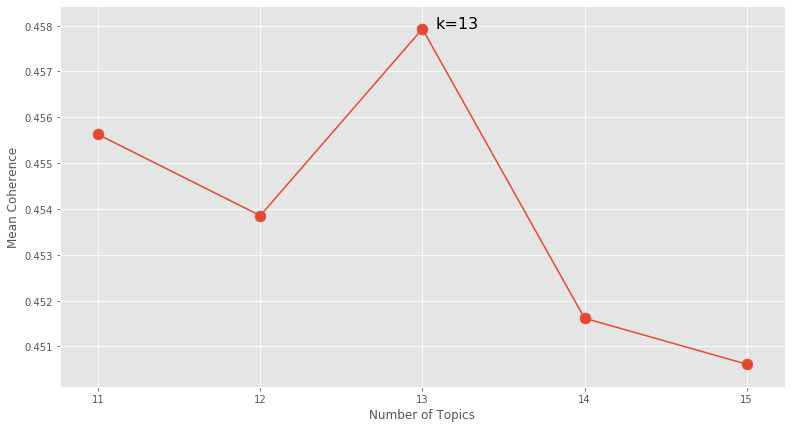

In [16]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()


### <font color=blue>Exercise</font>

Examine the plot above. The k with the highest mean coherence is likely most appropriate value for the number of topics. Change the best_value variable to highest coherence value.


In [17]:
k = 8 
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [19]:
print("W:", W)
print("H:", H)

W: [[0.         0.00322275 0.00039777 ... 0.         0.00059739 0.00721774]
 [0.         0.08590796 0.         ... 0.00938218 0.         0.02262467]
 [0.0001266  0.00115663 0.00054828 ... 0.0017303  0.00208022 0.08601944]
 ...
 [0.         0.00201432 0.02211288 ... 0.00501721 0.00617965 0.01781577]
 [0.03406835 0.         0.         ... 0.         0.02326523 0.        ]
 [0.         0.         0.05847927 ... 0.         0.00526998 0.        ]]
H: [[7.73142007e-02 1.32729691e-03 0.00000000e+00 ... 3.23813283e-03
  0.00000000e+00 0.00000000e+00]
 [3.60629071e-02 8.48545426e-05 0.00000000e+00 ... 1.81622541e-03
  0.00000000e+00 0.00000000e+00]
 [3.92309571e-02 1.41703504e-03 0.00000000e+00 ... 7.65689004e-04
  0.00000000e+00 0.00000000e+00]
 ...
 [1.18327284e-01 4.42678550e-03 1.60041198e-02 ... 3.60860681e-03
  0.00000000e+00 0.00000000e+00]
 [8.31080184e-03 1.55194355e-03 0.00000000e+00 ... 7.83292459e-03
  0.00000000e+00 0.00000000e+00]
 [4.42738206e-02 0.00000000e+00 0.00000000e+00 ...

### <font color=blue>Knowledge check</font>

- What does the codes in the above cells do ?
- Why is there a need to use [(k - kmin) as the index

In [ ]:
## Your answers



### <font color=blue>Exercise:</font>
1. Now that you have the optimal model, display the top terms for each topic (example below)
2. Show the top 5 documents snippets for topic 4

Hint: Refer to the previous exercise

In [ ]:
# Your codes